In [548]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import fukushima_telomere_methods as f_tm
import importlib

# for loading telo data column containing individual
# telomere length values
from ast import literal_eval

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
##### &nbsp; 

...

##### &nbsp; 
---

In [490]:
# setting all graphs to have darkgrid style w/ black edges for axes elements
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

### Loading New Dose Quantifications (+age/sex data), Cortisol, Telomere FISH, and Dicentric Data

In [757]:
trim_kelly_new_exposure_df = pd.read_csv('excel data/trim_kelly_new_exposure_df.csv')
prep_boar_cortisol_df = pd.read_csv('excel data/prep_boar_cortisol_df.csv')
kelly_boar_teloFISH_df = pd.read_csv('excel data/kelly_boar_teloFISH_df.csv')
kelly_boar_dicentrics_df = pd.read_csv('excel data/kelly_boar_dicentrics_df.csv')

### Merging Kelly's Telomere FISH data w/ New Dose Quantifications (+age/sex data)

In [805]:
merge_kelly_teloFISH_exposure = kelly_boar_teloFISH_df.merge(trim_kelly_new_exposure_df, on=['Sample ID'])
merge_kelly_teloFISH_exposure['Age (weeks)'] = merge_kelly_teloFISH_exposure['Age (weeks)'].apply(lambda row: f_tm.average_age_weeks(row))

# making new df for handling feature engineering of individual telo measurements, i.e counts of short/long telos 
place_hold_merge_kelly_teloFISH_exposure_telo_counts = merge_kelly_teloFISH_exposure.copy()

In [759]:
# merge_kelly_teloFISH_exposure['teloFISH data'] = merge_kelly_teloFISH_exposure['teloFISH data'].apply(lambda row: literal_eval(row))

In [760]:
print(
'','Data: Shape\n',
'kelly_boar_teloFISH_df',kelly_boar_teloFISH_df.shape,'\n',
'trim_kelly_new_exposure_df',trim_kelly_new_exposure_df.shape,'\n',
'prep_boar_cortisol_df',prep_boar_cortisol_df.shape,'\n',
'merge_kelly_teloFISH_exposure',merge_kelly_teloFISH_exposure.shape,'\n',)

 Data: Shape
 kelly_boar_teloFISH_df (41, 3) 
 trim_kelly_new_exposure_df (41, 15) 
 prep_boar_cortisol_df (48, 3) 
 merge_kelly_teloFISH_exposure (38, 17) 



In [761]:
cols_graph = ['INTERNAL uGy/h Cs-134', 
              'INTERNAL uGy/h Cs-137',
'INTERNAL Life time dose,   mGy 134',
'INTERNAL Life time dose, mGy 137',
'INTERNAL Life time dose, mGy 134+137',
'EXTERNAL Dose Reasonable Life Time, mGy (134+137)',
'% of INTERNAL to EXTERNAL dose',
'EXTERNAL Dose Maximum Life Time, mGy (134+137)',
'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',
'Maximum Total Life Time Dose mGy (Int+Ext,134+137)',
'Dose rate (uGy/h) at time of capture (Int+Ext; 134+137)']

In [762]:
merge_kelly_teloFISH_exposure.drop(index=34, inplace=True)
merge_kelly_teloFISH_exposure.replace('none', np.NaN, inplace=True)
merge_kelly_teloFISH_exposure.dropna(axis=0, inplace=True)

In [763]:
for column in cols_graph:
    merge_kelly_teloFISH_exposure[column] = merge_kelly_teloFISH_exposure[column].astype('float')
merge_kelly_teloFISH_exposure['Age (weeks)'] = merge_kelly_teloFISH_exposure['Age (weeks)'].astype('int')

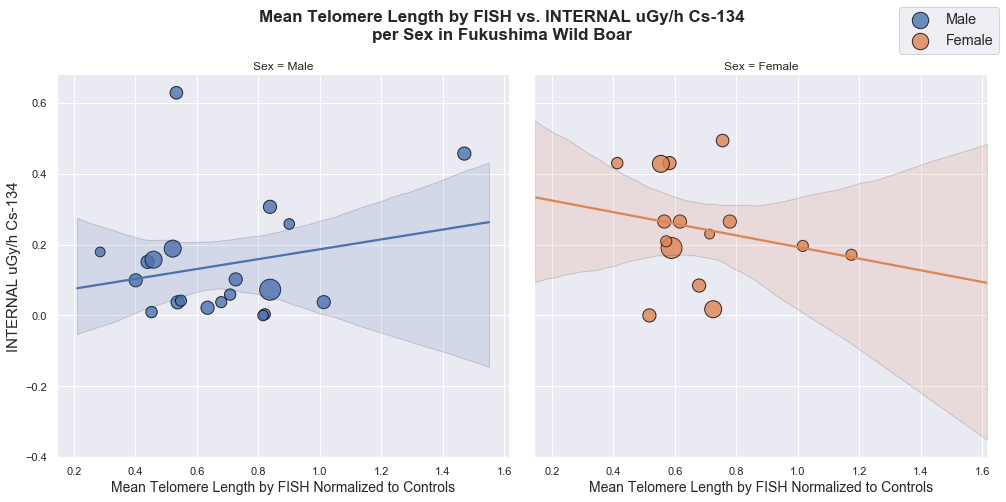

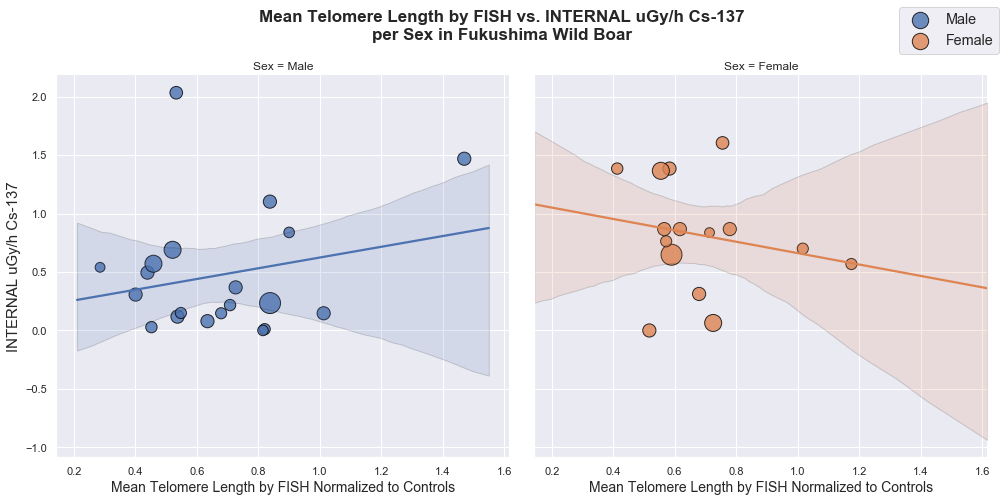

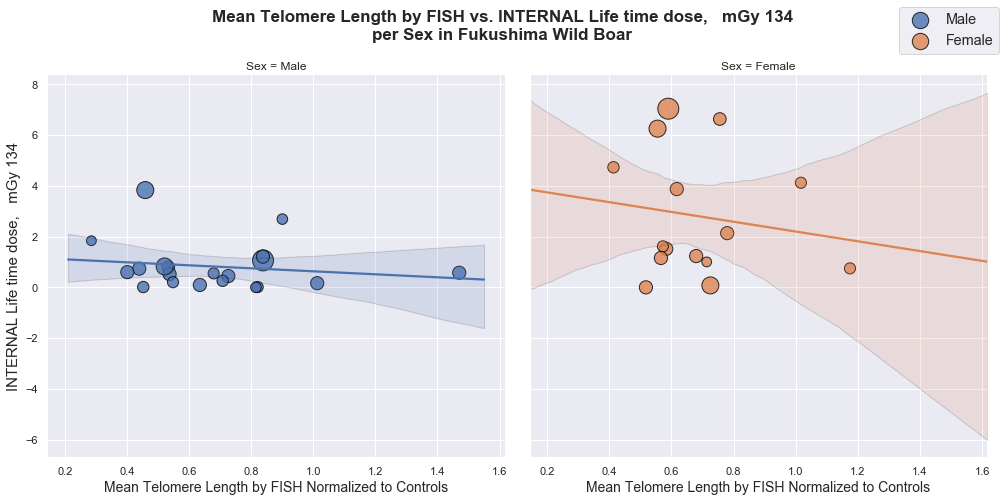

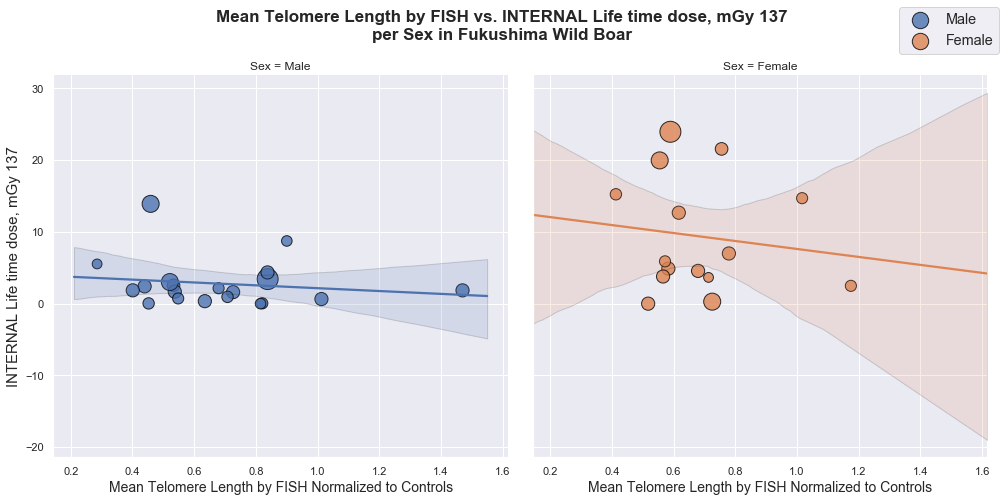

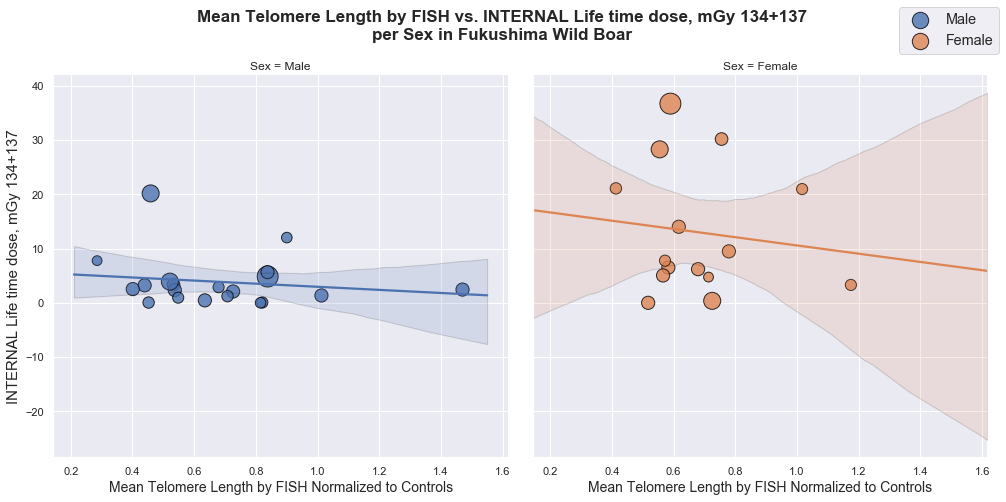

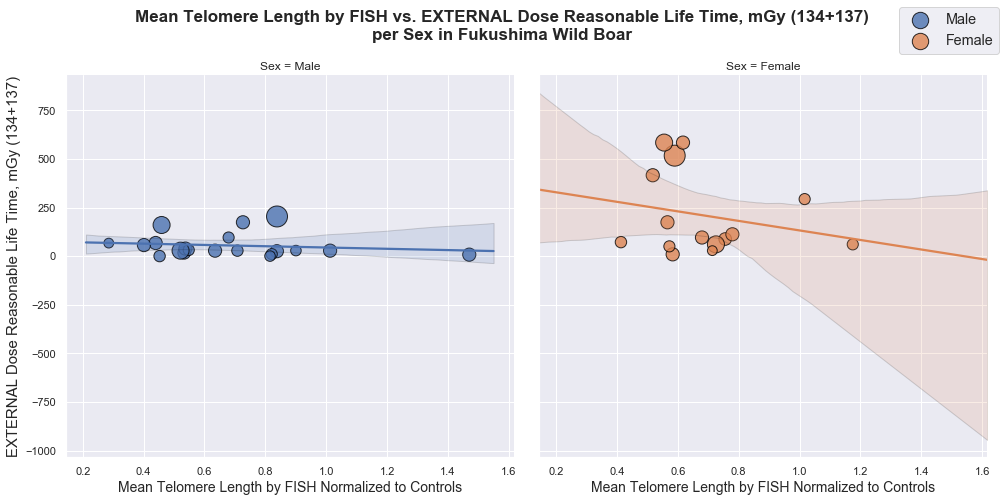

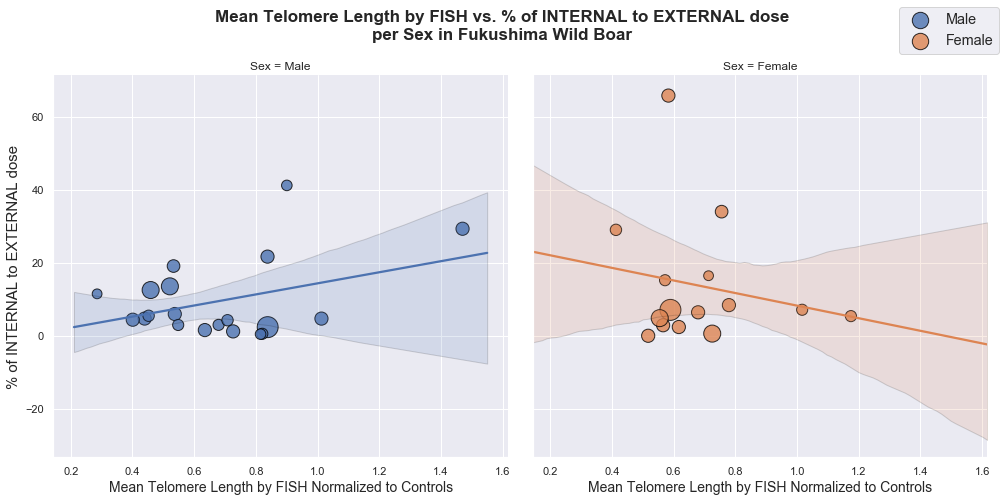

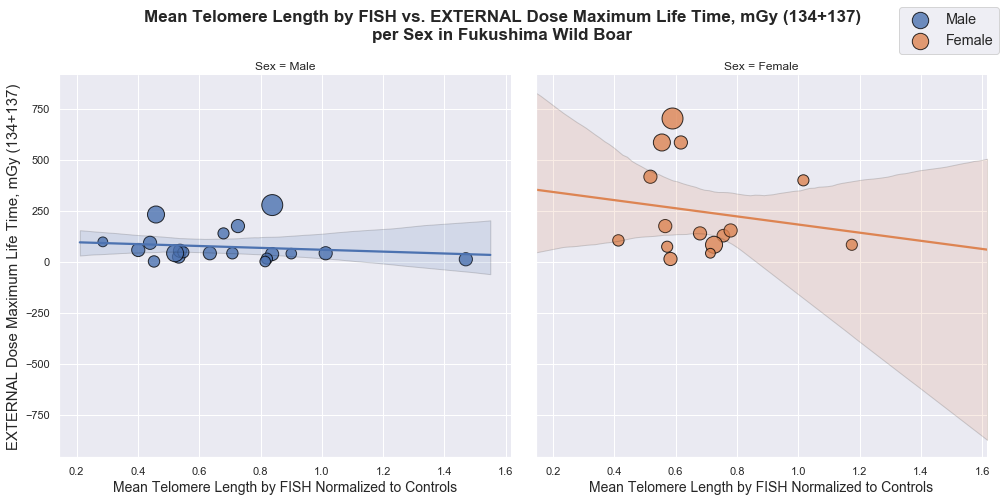

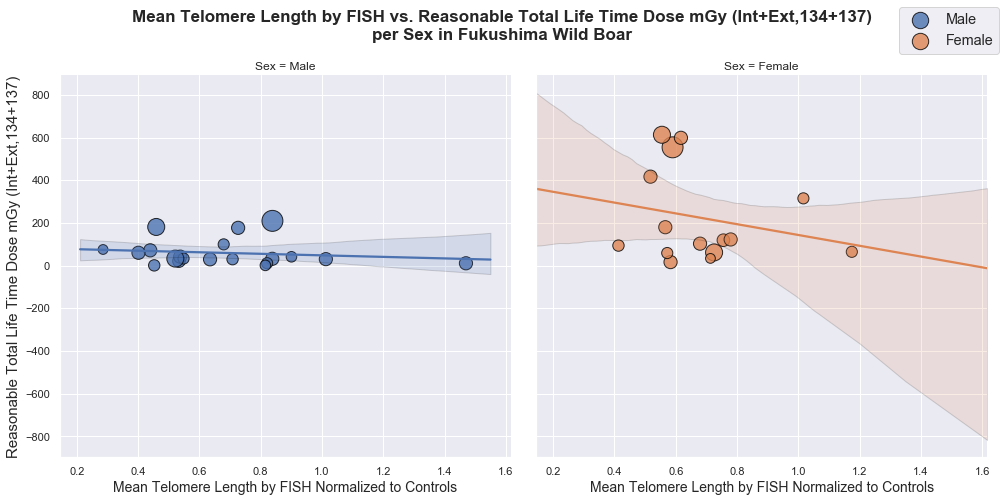

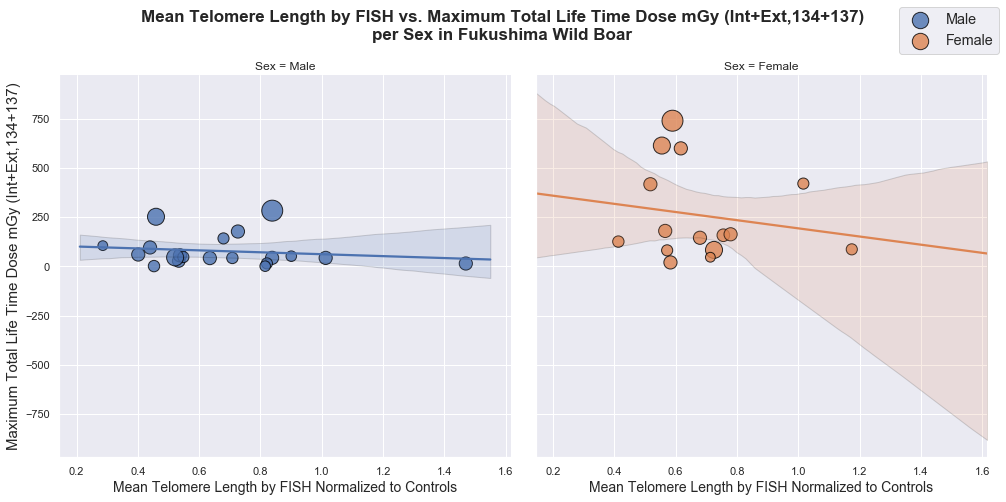

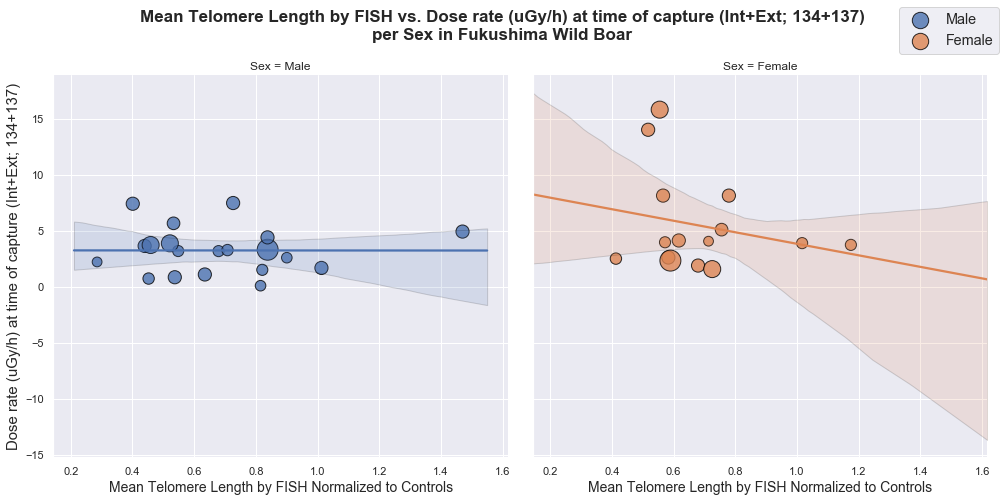

In [764]:
for y_title in cols_graph:
    
    if "/" in y_title:
        name_current = y_title.replace("/",'')
    else:
        name_current = y_title

    ax=sns.lmplot(x='teloFISH means', y=y_title, hue='Sex', col='Sex', data=merge_kelly_teloFISH_exposure,
    height=7, aspect=1, scatter_kws={"s": 2* merge_kelly_teloFISH_cortisol_exposure['Age (weeks)'], "edgecolor":'black'})
    
    fig = ax.fig 
    
    fig.suptitle(f'Mean Telomere Length by FISH vs. {y_title}\nper Sex in Fukushima Wild Boar', fontsize=17, weight='bold')
    ax.set_xlabels('Mean Telomere Length by FISH Normalized to Controls', fontsize=14)
    ax.set_ylabels(y_title, fontsize=15)
    plt.subplots_adjust(top=0.85)
    fig.legend(fontsize='large')
    
    ax.savefig(f"./graphs/Mean Telomere Length by FISH vs {name_current}.pdf")

### Investigating % short & long telomeres per teloFISH

In [806]:
# making new df for handling feature engineering of individual telo measurements, i.e counts of short/long telos 
merge_kelly_teloFISH_exposure_telo_counts = place_hold_merge_kelly_teloFISH_exposure_telo_counts
merge_kelly_teloFISH_exposure_telo_counts['teloFISH data'] = merge_kelly_teloFISH_exposure_telo_counts['teloFISH data'].apply(lambda row: literal_eval(row))

### Making dataframe containing all individual boar telomere length measurements

In [807]:
# making df consisting only of individual telomere length measurements
total_boar_telos_df = merge_kelly_teloFISH_exposure_telo_counts['teloFISH data'].apply(pd.Series)
print(total_boar_telos_df.shape)

(38, 4800)


In [808]:
# reshaping df so that all individual telo measurements are in one column
total_boar_telos_vector_df = pd.DataFrame(total_boar_telos_df.values.reshape(-1,1))
print(total_boar_telos_vector_df.shape)

(182400, 1)


Counting # of individual telomeres PER boar that fall below the 0.25, within the 0.25-0.75 range, & above 0.75 quantile established by the population of individual telomeres from ALL boar.

This allows us to describe the individual telomere length distribution per boar relative to the population of all individual telomere length measurements.

In [809]:
# making columns to hold the count data
for col in ['Q1', 'Q2-3', 'Q4']:
    merge_kelly_teloFISH_exposure_telo_counts[col] = 'fill'
    
# feature engineering counts of # individual telos per boar that fall below the 0.25, within the 0.25-0.75 range, & above 0.75 quantile 
merge_kelly_teloFISH_exposure_telo_counts = f_tm.make_quartiles_columns(total_boar_telos_vector_df, merge_kelly_teloFISH_exposure_telo_counts)

# ensuring int type of data
for col in ['Q1', 'Q2-3', 'Q4']:
    merge_kelly_teloFISH_exposure_telo_counts[col] = merge_kelly_teloFISH_exposure_telo_counts[col].astype('int')

# feature engineering % short, medium long telos from the quartile 
# (% type) = (# counts / 4800 total telos per sample) * 100
telo_types = ['% short telomeres', '% medium telomeres', '% long telomeres']
quartiles = ['Q1', 'Q2-3', 'Q4']

for t_type, quart in zip(telo_types, quartiles):
    merge_kelly_teloFISH_exposure_telo_counts[t_type] = (merge_kelly_teloFISH_exposure_telo_counts[quart] / 4800) * 100
    
for t_type in telo_types:
    merge_kelly_teloFISH_exposure_telo_counts[t_type] = merge_kelly_teloFISH_exposure_telo_counts[t_type].astype('int')

In [811]:
merge_kelly_teloFISH_exposure_telo_counts.drop(index=34, inplace=True)
merge_kelly_teloFISH_exposure_telo_counts.replace('none', np.NaN, inplace=True)
merge_kelly_teloFISH_exposure_telo_counts.dropna(axis=0, inplace=True)

for column in cols_graph:
    merge_kelly_teloFISH_exposure_telo_counts[column] = merge_kelly_teloFISH_exposure_telo_counts[column].astype('float')
    
merge_kelly_teloFISH_exposure_telo_counts['Age (weeks)'] = merge_kelly_teloFISH_exposure_telo_counts['Age (weeks)'].astype('int')

In [812]:
print(merge_kelly_teloFISH_exposure_telo_counts.shape,
     merge_kelly_teloFISH_exposure.shape)

(35, 23) (38, 17)


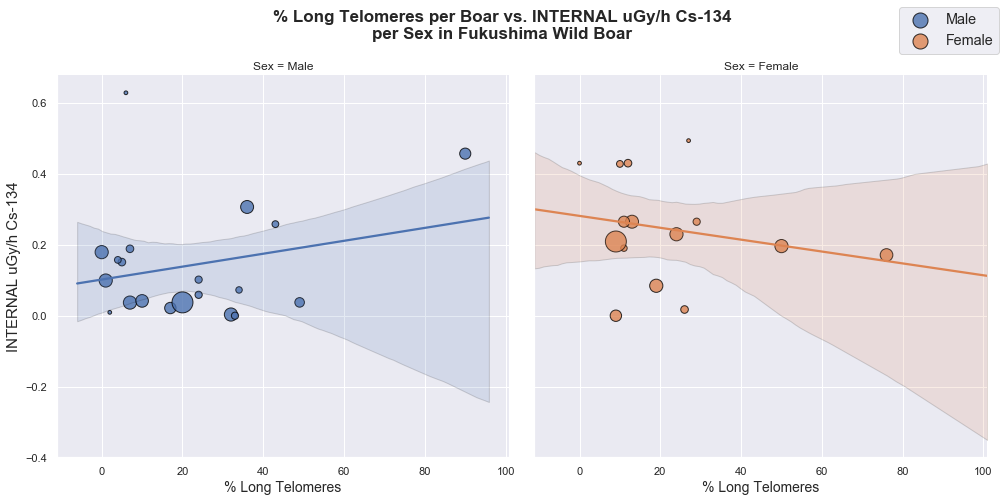

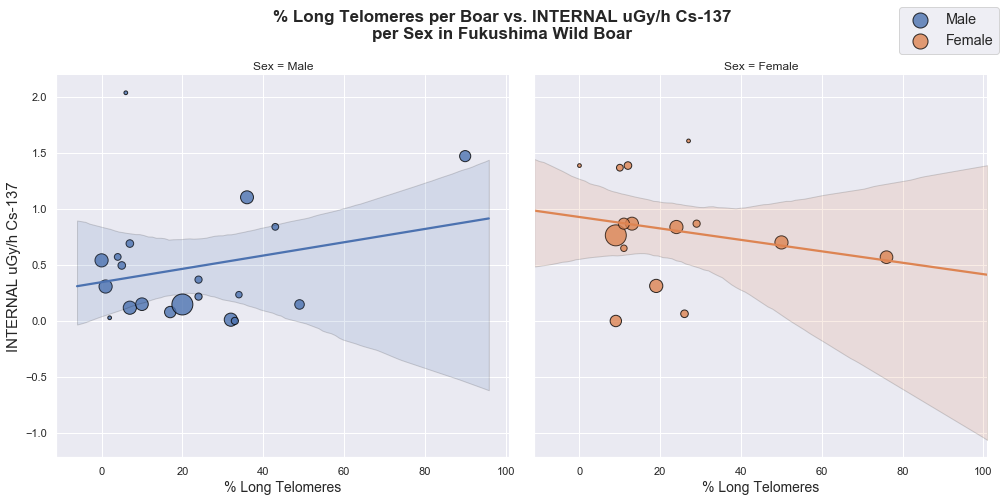

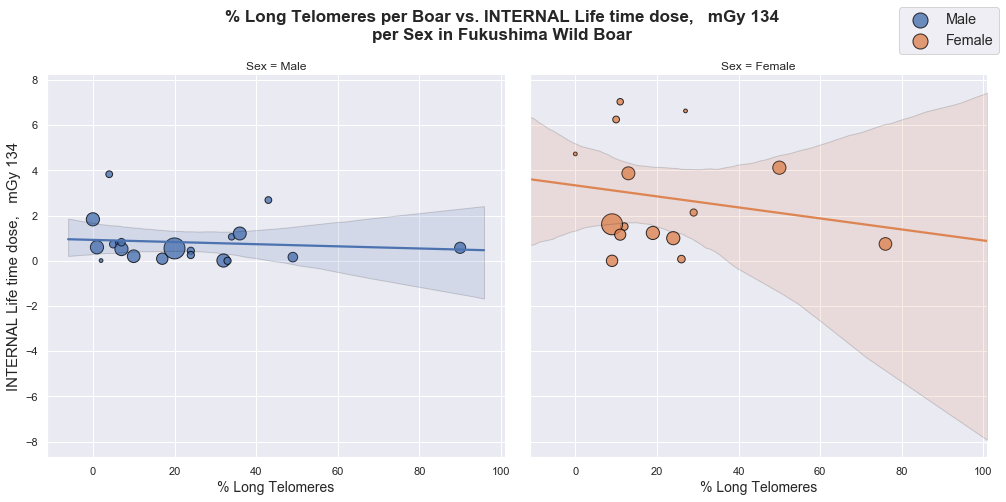

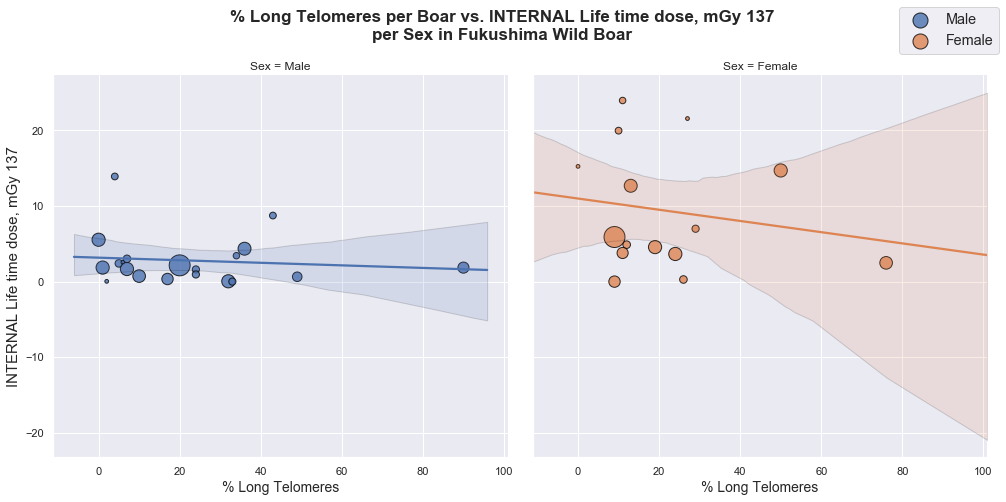

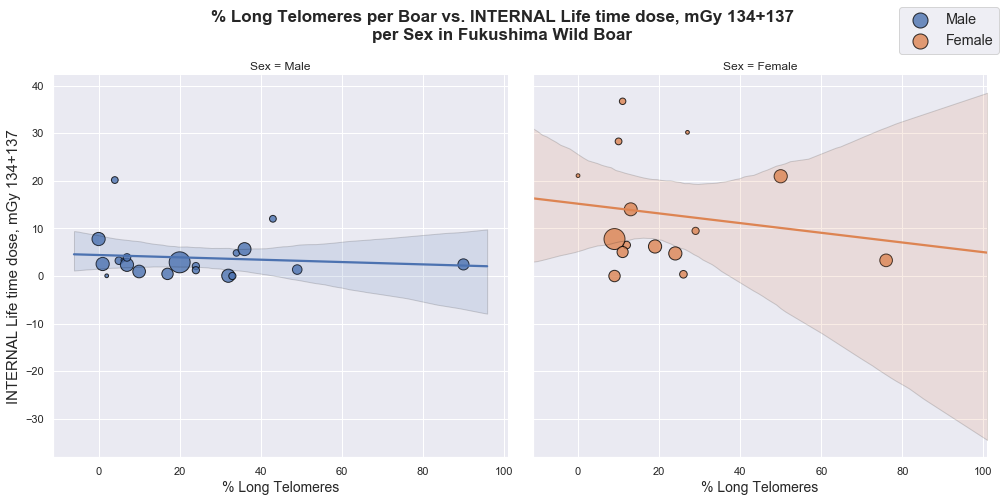

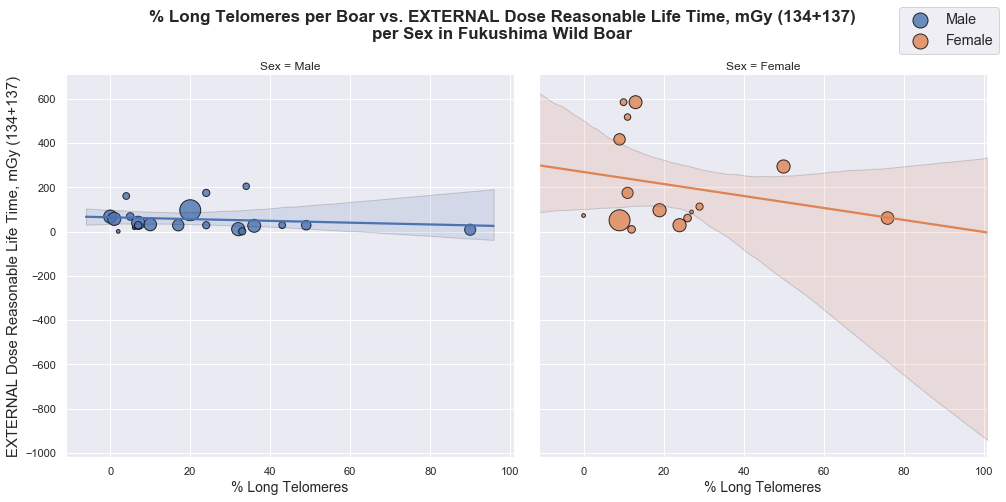

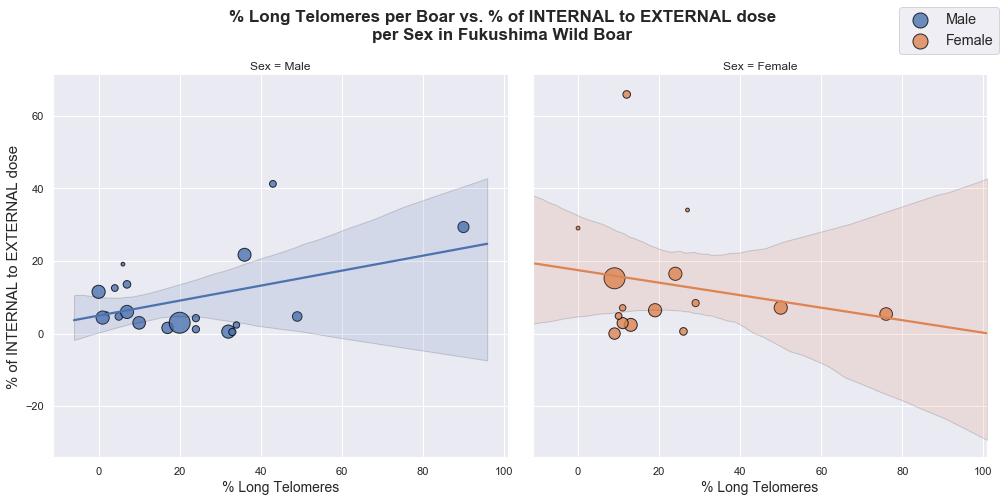

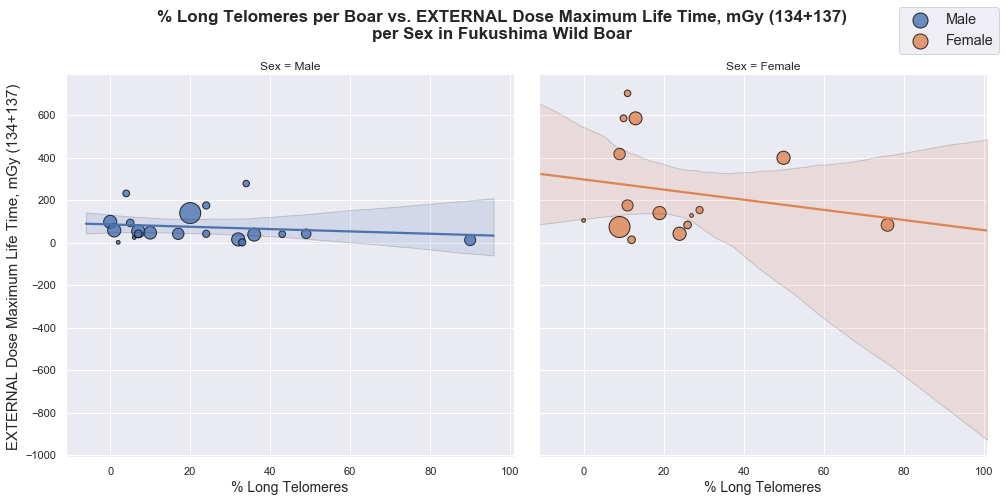

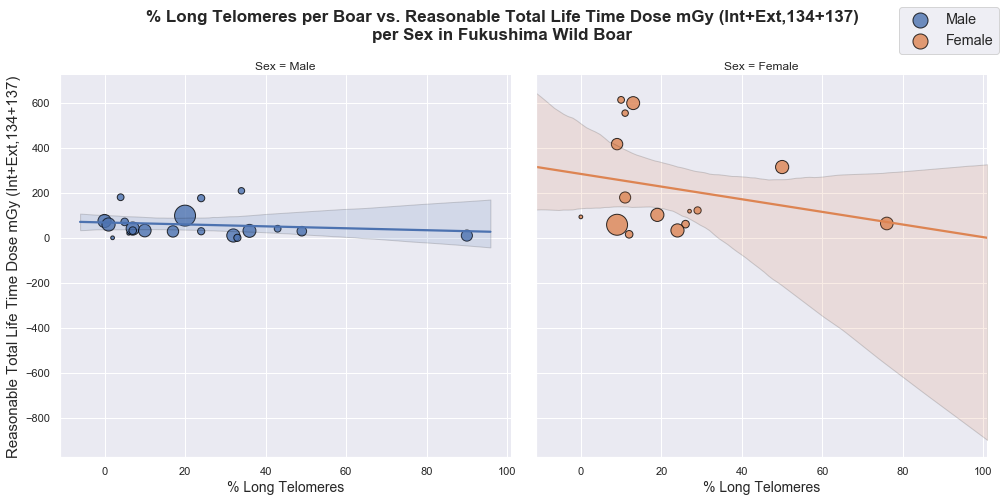

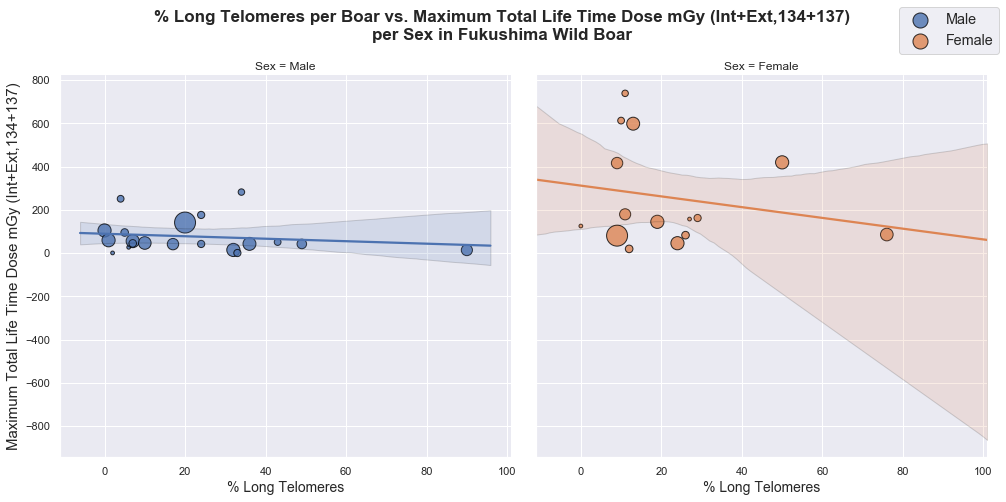

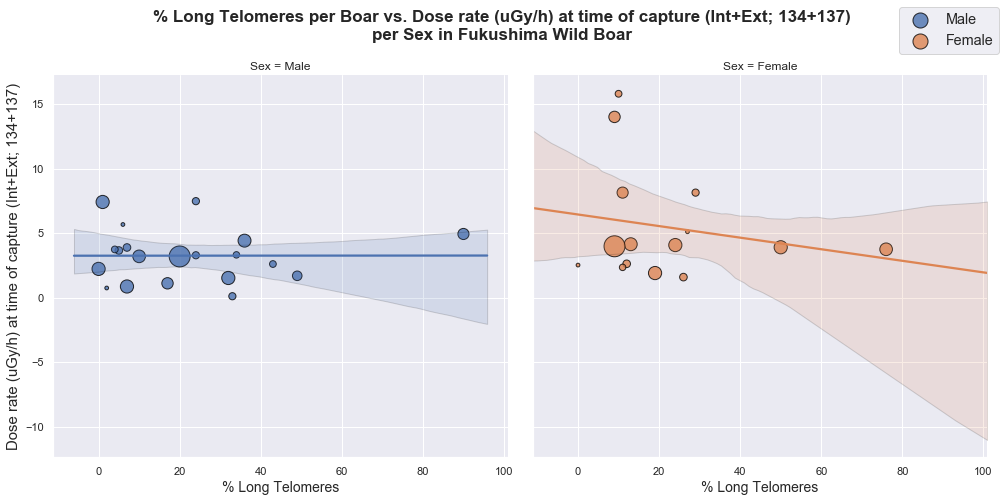

In [817]:
for y_title in cols_graph:
    
    if "/" in y_title:
        name_current = y_title.replace("/",'')
    else:
        name_current = y_title

    ax=sns.lmplot(x='% long telomeres', y=y_title, hue='Sex', col='Sex', data=merge_kelly_teloFISH_exposure_telo_counts,
    height=7, aspect=1, 
                  scatter_kws={"s": 2* merge_kelly_teloFISH_exposure_telo_counts['Age (weeks)'], "edgecolor":'black'})

    fig = ax.fig 

    fig.suptitle(f'% Long Telomeres per Boar vs. {y_title}\nper Sex in Fukushima Wild Boar', fontsize=17, weight='bold')
    ax.set_xlabels('% Long Telomeres', fontsize=14)
    ax.set_ylabels(y_title, fontsize=15)
    plt.subplots_adjust(top=0.85)
    fig.legend(fontsize='large')
    
    ax.savefig(f"./graphs/% long telomeres vs {name_current}.pdf")

In [ ]:
merge_kelly_teloFISH_cortisol_exposure = merge_kelly_teloFISH_exposure.merge(prep_boar_cortisol_df, on=['Sample ID'])

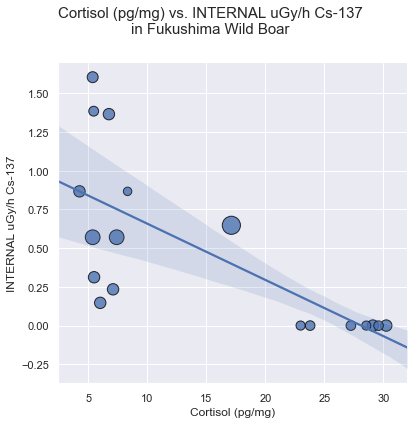

In [173]:
x='Cortisol (pg/mg)'
y='INTERNAL uGy/h Cs-137'
data=merge_kelly_teloFISH_cortisol_exposure
hue=None
col=None

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 1.5* merge_kelly_teloFISH_cortisol_exposure['Age (weeks)'], 
                                                 "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nin Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.85)

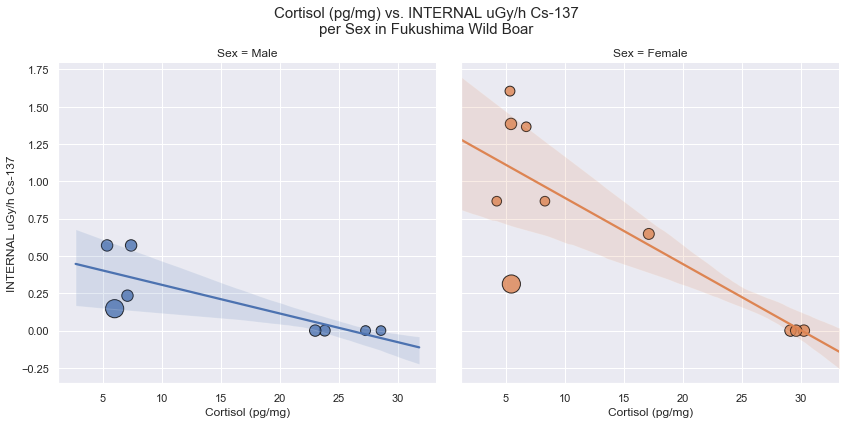

In [174]:
x='Cortisol (pg/mg)'
y='INTERNAL uGy/h Cs-137'
data=merge_kelly_teloFISH_cortisol_exposure
hue='Sex'
col='Sex'

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 1.5* merge_kelly_teloFISH_cortisol_exposure['Age (weeks)'], 
                                                 "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nper {hue} in Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.85)

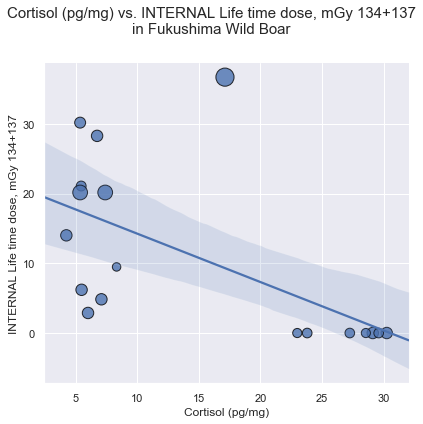

In [165]:
x='Cortisol (pg/mg)'
y='INTERNAL Life time dose, mGy 134+137'
data=merge_kelly_teloFISH_cortisol_exposure
hue=None
col=None

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 1.5* merge_kelly_teloFISH_cortisol_exposure['Age (weeks)'], 
                                                 "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nin Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.85)

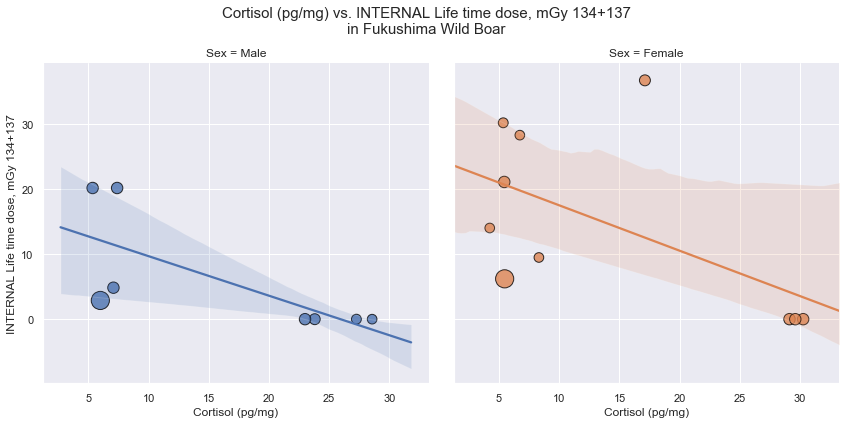

In [166]:
x='Cortisol (pg/mg)'
y='INTERNAL Life time dose, mGy 134+137'
data=merge_kelly_teloFISH_cortisol_exposure
hue='Sex'
col='Sex'

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 1.5* merge_kelly_teloFISH_cortisol_exposure['Age (weeks)'],
                                                 "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nin Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.85)

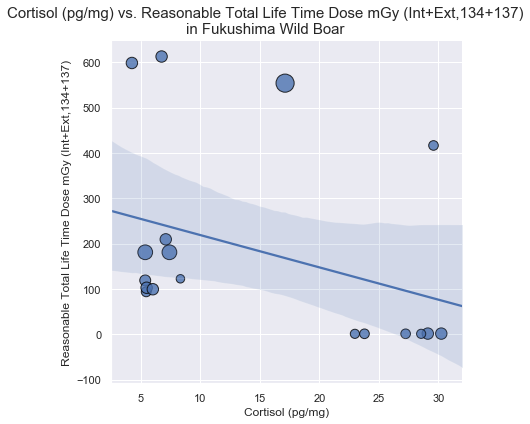

In [167]:
x='Cortisol (pg/mg)'
y='Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
data=merge_kelly_teloFISH_cortisol_exposure
hue=None
col=None

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 1.5* merge_kelly_teloFISH_cortisol_exposure['Age (weeks)'],
                                                 "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nin Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.9)

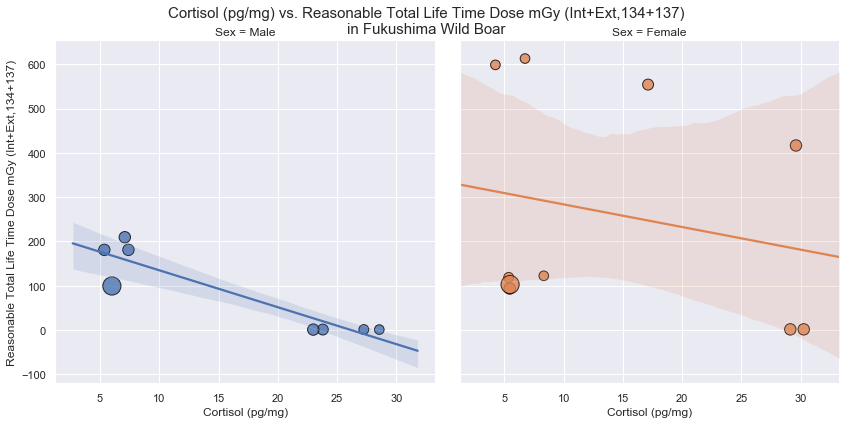

In [168]:
x='Cortisol (pg/mg)'
y='Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
data=merge_kelly_teloFISH_cortisol_exposure
hue='Sex'
col='Sex'

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 1.5* merge_kelly_teloFISH_cortisol_exposure['Age (weeks)'],
                                                 "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nin Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.9)

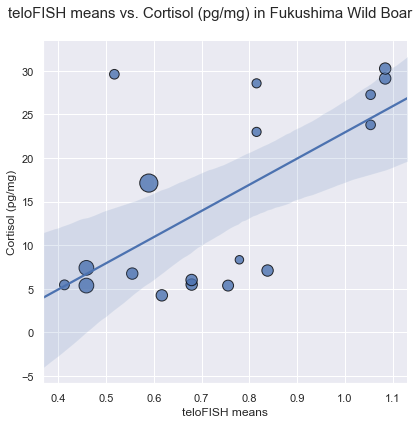

In [169]:
x='teloFISH means'
y='Cortisol (pg/mg)'
data=merge_kelly_teloFISH_cortisol_exposure
hue=None
col=None

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 1.5* merge_kelly_teloFISH_cortisol_exposure['Age (weeks)'],
                                                 "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y} in Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.9)

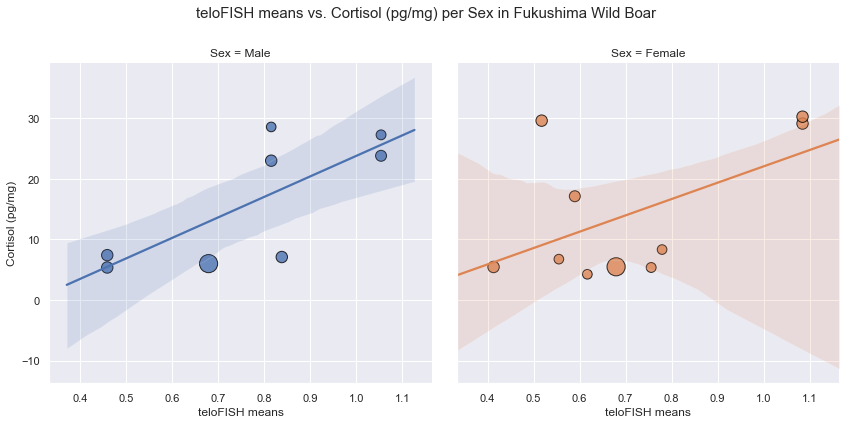

In [170]:
x='teloFISH means'
y='Cortisol (pg/mg)'
data=merge_kelly_teloFISH_cortisol_exposure
hue='Sex'
col='Sex'

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 1.5* merge_kelly_teloFISH_cortisol_exposure['Age (weeks)'],
                                                 "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y} per {hue} in Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.85)

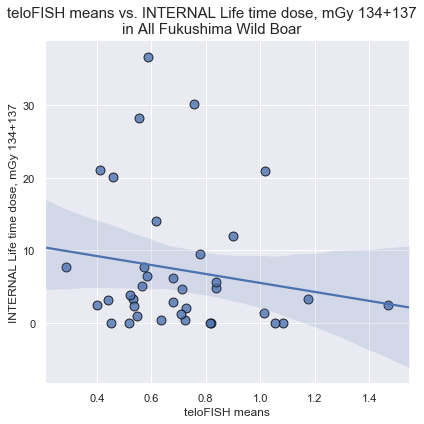

In [291]:
x='teloFISH means'
y='INTERNAL Life time dose, mGy 134+137'
data=merge_kelly_teloFISH_exposure
hue=None
col=None

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 80, "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nin All Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.9)

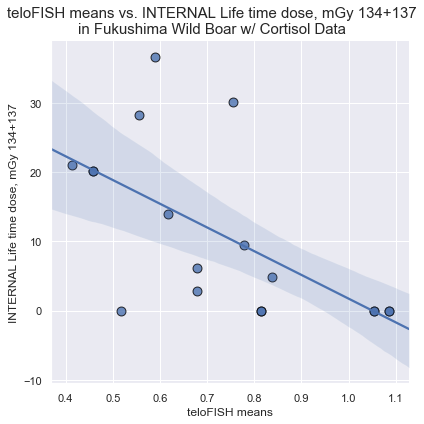

In [125]:
x='teloFISH means'
y='INTERNAL Life time dose, mGy 134+137'
data=merge_kelly_teloFISH_cortisol_exposure
col=None

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 80, "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nin Fukushima Wild Boar w/ Cortisol Data', fontsize=15,)
plt.subplots_adjust(top=0.9)

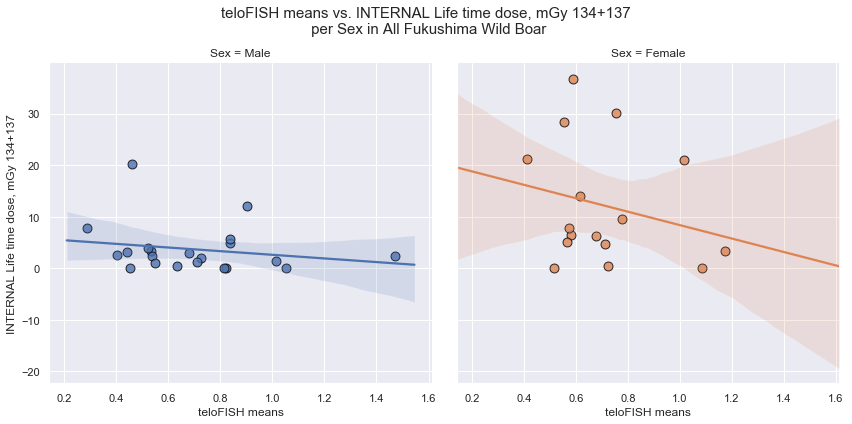

In [172]:
x='teloFISH means'
y='INTERNAL Life time dose, mGy 134+137'
data=merge_kelly_teloFISH_exposure
hue='Sex'
col='Sex'

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 80, "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\n per {hue} in All Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=.85)

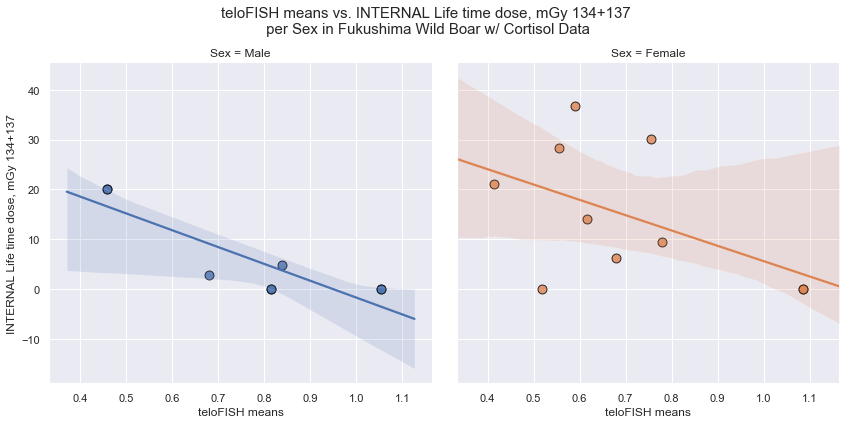

In [127]:
x='teloFISH means'
y='INTERNAL Life time dose, mGy 134+137'
data=merge_kelly_teloFISH_cortisol_exposure
hue='Sex'
col='Sex'

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 80, "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\n per {hue} in Fukushima Wild Boar w/ Cortisol Data', fontsize=15,)
plt.subplots_adjust(top=.85)

In [248]:
aryn_boar_df = pd.read_csv('excel data/aryn_boar_df.csv')

aryn_snake_df = pd.read_csv('excel data/aryn_snake_df.csv')

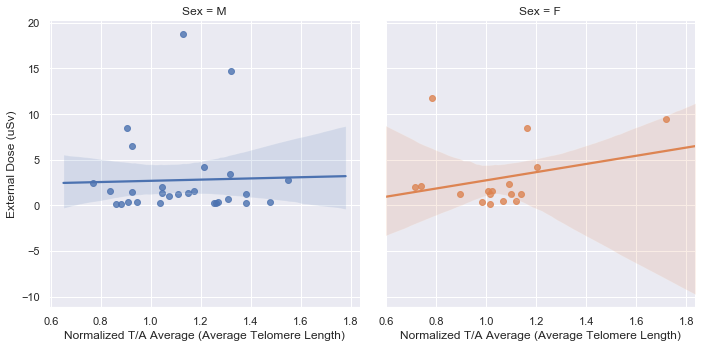

In [260]:
sns.lmplot(x='Normalized T/A Average (Average Telomere Length)', y='External Dose (uSv)', hue='Sex', col='Sex', data=aryn_boar_df)

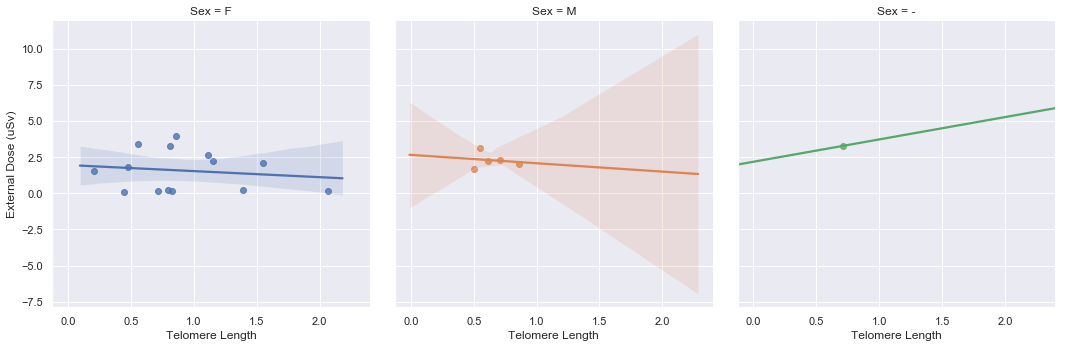

In [254]:
sns.lmplot(x='Telomere Length', y='External Dose (uSv)', col='Sex', hue='Sex', data=aryn_snake_df)

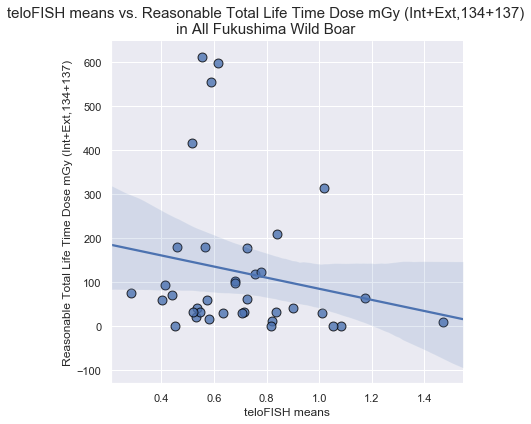

In [129]:
x='teloFISH means'
y='Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
data=merge_kelly_teloFISH_exposure
hue=None
col=None

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 80, "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nin All Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.9)

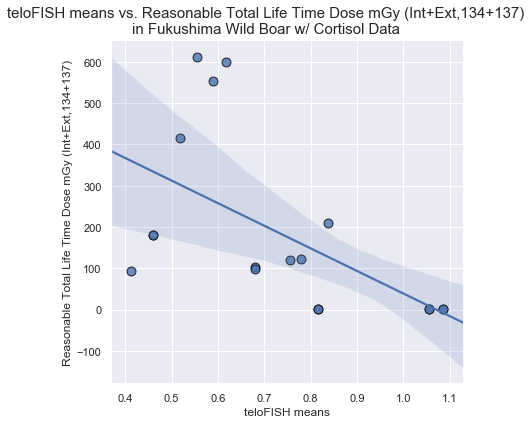

In [130]:
x='teloFISH means'
y='Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
data=merge_kelly_teloFISH_cortisol_exposure
hue=None
col=None

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 80, "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nin Fukushima Wild Boar w/ Cortisol Data', fontsize=15,)
plt.subplots_adjust(top=0.9)

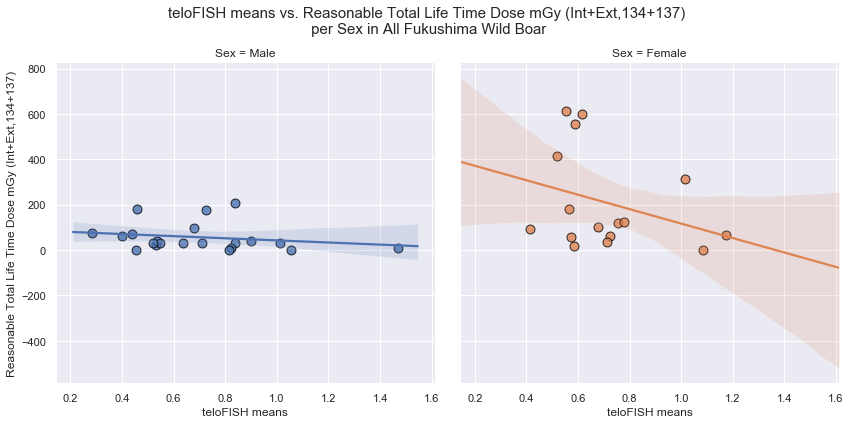

In [131]:
x='teloFISH means'
y='Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
data=merge_kelly_teloFISH_exposure
hue='Sex'
col='Sex'

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 80, "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\n per {hue} in All Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.85)

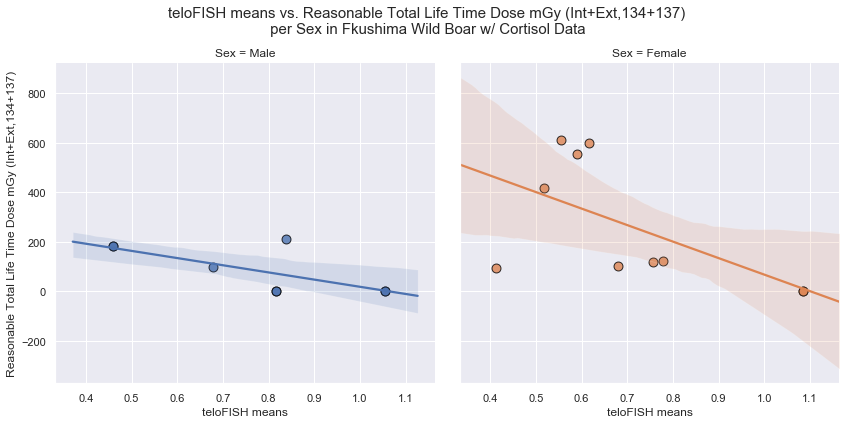

In [132]:
x='teloFISH means'
y='Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
data=merge_kelly_teloFISH_cortisol_exposure
hue='Sex'
col='Sex'

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 80, "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\n per {hue} in Fkushima Wild Boar w/ Cortisol Data', fontsize=15,)
plt.subplots_adjust(top=0.85)

In [17]:
merge_kelly_teloFISH_cortisol = kelly_boar_teloFISH_df.merge(prep_boar_cortisol_df, on=['Sample ID'])

,Sample ID,teloFISH data,teloFISH mean,Sample Number (electronic sheet),Cortisol (pg/mg)
0,1607262,"[0.9495239580254556, 0.664666770617819, 0.5920...",0.838296,160726-2,7.087576
1,1607281,"[0.5138600243431878, 0.3909804533045994, 0.703...",0.413094,160728-1,5.445329
2,1607264,"[1.023276324031662, 0.7849790978873024, 1.0443...",0.755637,160726-4,5.360000
3,1611301O210,"[0.3083846455985831, 0.8620752592869482, 0.266...",0.589711,161130-1 O-210 collar,17.120000


In [218]:
josh_ppha_df = pd.read_excel('excel data/PPHA concentration (1).xlsx')

In [219]:
trimmed_josh_ppha_df = josh_ppha_df.iloc[0:38, 9:15]
trimmed_josh_ppha_df.rename(columns={'Boar ID':'Sample ID'}, inplace=True)
trimmed_josh_ppha_df['Sample ID'] = trimmed_josh_ppha_df['Sample ID'].astype('str')
trimmed_josh_ppha_df['Sample ID'] = trimmed_josh_ppha_df['Sample ID'].apply(lambda row: f_tm.remove_dashes_space_sampleIDs(row))

In [220]:
josh_ppha_df_cortisol = trimmed_josh_ppha_df.merge(prep_boar_cortisol_df, on=['Sample ID'])

In [227]:
josh_ppha_df_cortisol.head(4)

,Sample ID,PPHAs,Normal Neutrophils,Total cells counted,Gy,%PPHA,Sample Number (electronic sheet),Cortisol (pg/mg)
0,Ba20170615,4,537.0,541.0,0.43770,0.739372,Ba20170615,10.067764
1,Ba180110,1,1004.0,1005.0,0.00104,0.099502,Ba180110_ear,13.280000
2,Bb180110,0,1004.0,1004.0,0.00054,0.000000,Bb180110_ear,7.393270
3,Bc180110,2,603.0,605.0,0.00077,0.330579,Bc180110_ear,10.676285


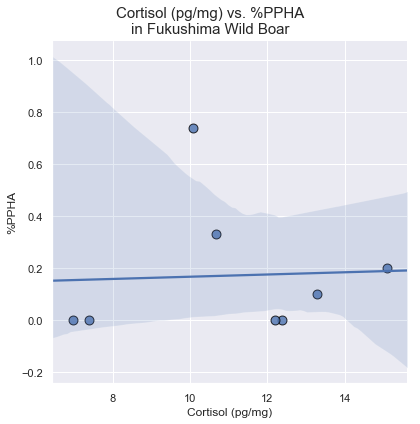

In [223]:
x='Cortisol (pg/mg)'
y='%PPHA'
data=josh_ppha_df_cortisol
hue=None
col=None

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 80, "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nin Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.9)

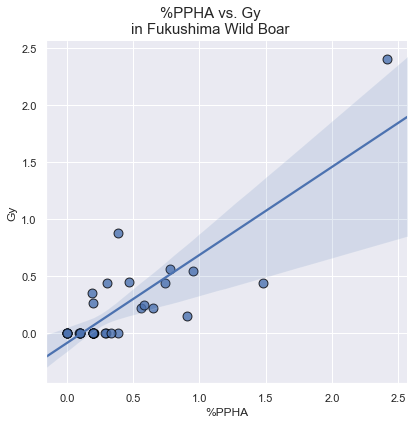

In [228]:
x='%PPHA'
y='Gy'
data=trimmed_josh_ppha_df
hue=None
col=None

ax = sns.set(font_scale=1)
ax = sns.lmplot(x=x, y=y, hue=hue, col=col, data=data, 
                height=6, aspect=1, scatter_kws={"s": 80, "edgecolor":'black'})

fig = ax.fig 
fig.suptitle(f'{x} vs. {y}\nin Fukushima Wild Boar', fontsize=15,)
plt.subplots_adjust(top=0.9)

In [287]:
kelly_dicentrics = pd.read_csv('excel data/kelly_boar_dicentrics_df.csv')

merge_test = merge_kelly_teloFISH_exposure.merge(kelly_dicentrics, on=['Sample ID'])

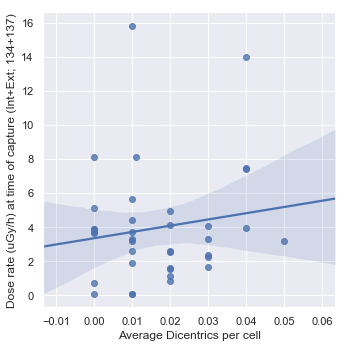

In [285]:
sns.lmplot(x='Average Dicentrics per cell',y='Dose rate (uGy/h) at time of capture (Int+Ext; 134+137)',data=merge_test)

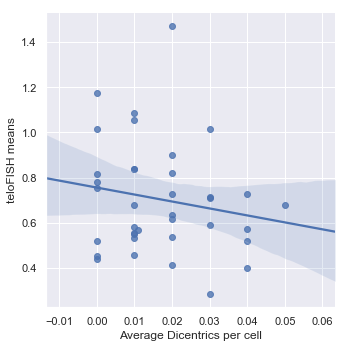

In [286]:
sns.lmplot(x='Average Dicentrics per cell',y='teloFISH means',data=merge_test)